# Cleaning Data in Python

In [ ]:
!pip install missingno
!pip install fuzzywuzzy
!pip install recordlinkage


In [1]:

# Import the course packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import missingno as msno
import fuzzywuzzy
import recordlinkage 

# Import the course datasets
ride_sharing = pd.read_csv('ride_sharing_new.csv', index_col = 'Unnamed: 0')
airlines = pd.read_csv('airlines_final.csv',  index_col = 'Unnamed: 0')
banking = pd.read_csv('banking_dirty.csv', index_col = 'Unnamed: 0')
restaurants = pd.read_csv('restaurants_L2.csv', index_col = 'Unnamed: 0')
restaurants_new = pd.read_csv('restaurants_L2_dirty.csv', index_col = 'Unnamed: 0')

## Common data problems

* data type constraints `.dtypes` `.info()`
    * `.astype()`
* string to integer - `.str.strip()`
* `assert condition` returns nothing if condition is met, error if it isn't
* `.describe()` for category

In [3]:
# Print the information of ride_sharing
print(ride_sharing.info())

# Print summary statistics of user_type column
print(ride_sharing['user_type'].describe())

# Convert user_type from integer to category
ride_sharing['user_type_cat'] = ride_sharing['user_type'].astype('category')

# Write an assert statement confirming the change
assert ride_sharing['user_type_cat'].dtype == 'category'

# Print new summary statistics 
print(ride_sharing['user_type_cat'].describe())

<class 'pandas.core.frame.DataFrame'>
Index: 25760 entries, 0 to 25759
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   duration         25760 non-null  object
 1   station_A_id     25760 non-null  int64 
 2   station_A_name   25760 non-null  object
 3   station_B_id     25760 non-null  int64 
 4   station_B_name   25760 non-null  object
 5   bike_id          25760 non-null  int64 
 6   user_type        25760 non-null  int64 
 7   user_birth_year  25760 non-null  int64 
 8   user_gender      25760 non-null  object
dtypes: int64(5), object(4)
memory usage: 2.0+ MB
None
count    25760.000000
mean         2.008385
std          0.704541
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: user_type, dtype: float64
count     25760
unique        3
top           2
freq      12972
Name: user_type_cat, dtype: int64


In [4]:
# Strip duration of minutes
ride_sharing['duration_trim'] = ride_sharing['duration'].str.strip('minutes')

# Convert duration to integer
ride_sharing['duration_time'] = ride_sharing['duration_trim'].astype(int)

# Write an assert statement making sure of conversion
assert ride_sharing['duration_time'].dtype == 'int'

# Print formed columns and calculate average ride duration 
print(ride_sharing[['duration','duration_trim','duration_time']])
print(ride_sharing['duration_time'].mean())

         duration duration_trim  duration_time
0      12 minutes           12              12
1      24 minutes           24              24
2       8 minutes            8               8
3       4 minutes            4               4
4      11 minutes           11              11
...           ...           ...            ...
25755  11 minutes           11              11
25756  10 minutes           10              10
25757  14 minutes           14              14
25758  14 minutes           14              14
25759  29 minutes           29              29

[25760 rows x 3 columns]
11.389052795031056


### range

* values out of range
* future date (greater than `.date.today()`)

**options**
* drop data (only if small amount)
* custom mins and maxs
* treat as missing and impute
* set custom valeu depending on business assumption (default)

**dropping**
* filter df = df[df['col'] > value]
* drop df.drop(df[df['col'] > value].index, inplace = True)

**hard limit**
df.loc[df['col'] > value, 'col'] = limit

**dates**
```python
# convert to date
df['datecol'] = pd.to_datetime(df['datecol']).dt.date
today_date = dt.date.today()

# drop values with filtering
df = df[df['datecol'] < today_date]
# drop using .drop()
df.drop(df[df['datecol'] > today_date].index, inplace = True)

# replace
df.loc[df['datecol'] > today_date, 'datecol'] = today_date
# assert 
assert df.datecol.max().date() <= today_date

```

In [ ]:
# Convert tire_sizes to integer
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('int')

# Set all values above 27 to 27
ride_sharing.loc[ride_sharing['tire_sizes'] > 27, 'tire_sizes'] = 27

# Reconvert tire_sizes back to categorical
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('category')

# Print tire size description
print(ride_sharing['tire_sizes'].describe())

In [ ]:
# Convert ride_date to date
ride_sharing['ride_dt'] = pd.to_datetime(ride_sharing['ride_date']).dt.date

# Save today's date
today = dt.date.today()

# Set all in the future to today's date
ride_sharing.loc[ride_sharing['ride_dt'] > today, 'ride_dt'] = today

# Print maximum of ride_dt column
print(ride_sharing['ride_dt'].max())

### uniqueness, duplicate values

* `.duplicated()`
    * `subset` list of column names to check for duplication
    * `keep` whether to keep **first** (`first`), **last** (`last`), or **all** (`False`) duplicate values

column_names = ['first_name', 'last_name', 'address']
duplicates = height_weight.duplicated[subset = column_names, keep = False]

height_weight[duplicates].sort_values(by = 'first_name')

* may result in `complete` or `incomplete` dupicates:

* `.drop_duplicates()` with `subset` and `keep` and `inplace`

height_weight.drop_duplicates(inplace = True) # first is default


* can combine duplicated rows using statistical measures and .agg()

```python

column_names = ['first_name', 'last_name', 'address']
summaries = {'height': 'max', 'weight': 'mean'}
height_weight = height_weight.groupby(by = column_names).agg(summaries).reset_index()
```


In [ ]:
# Find duplicates
duplicates = ride_sharing.duplicated(subset = ['ride_id'], keep=False)

# Sort your duplicated rides
duplicated_rides = ride_sharing[duplicates].sort_values('ride_id')

# Print relevant columns of duplicated_rides
print(duplicated_rides[['ride_id','duration','user_birth_year']])

In [ ]:
# Drop complete duplicates from ride_sharing
ride_dup = ride_sharing.drop_duplicates()

# Create statistics dictionary for aggregation function
statistics = {'user_birth_year': 'min', 'duration': 'mean'}

# Group by ride_id and compute new statistics
ride_unique = ride_dup.groupby(by ='ride_id').agg(statistics).reset_index()

# Find duplicated values again
duplicates = ride_unique.duplicated(subset = 'ride_id', keep = False)
duplicated_rides = ride_unique[duplicates == True]

# Assert duplicates are processed
assert duplicated_rides.shape[0] == 0

## Text and categorical data problems

### membership constraints

* categories - predefined, limited 
* treat issues: 
  * drop data
  * remap categories
  * infer categories

example:

study_data = blood types
categories = acceptable types

joins: 
* anti joins - what is in A and not in B
* inner join - what is in both A and B

* inconsistent categories:
* `inconsisten_categories = set(study_data['blood_type']).difference(categories['blood_type'])`
* `inconsistent_rows = study_data['blood_type'].isin(inconsistent_categories)`
* `study_data[inconsistent_rows]`
* `consistent_data = study_data[~inconsistent_rows]`

In [9]:
# save unique values of airlines columns cleanliness, safety, satisfaction to df
cleanliness = airlines['cleanliness'].unique()
safety = airlines['safety'].unique()
satisfaction = airlines['satisfaction'].unique()
categories = pd.DataFrame({'cleanliness': cleanliness, 'safety': safety, 'satisfaction': satisfaction})
print(categories)


# Print unique values of survey columns in airlines
print('Cleanliness: ', airlines['cleanliness'].unique(), "\n")
print('Safety: ', airlines['safety'].unique(), "\n")
print('Satisfaction: ', airlines['satisfaction'].unique(), "\n")



      cleanliness           safety          satisfaction
0           Clean          Neutral        Very satisfied
1         Average        Very safe               Neutral
2  Somewhat clean    Somewhat safe    Somewhat satsified
3  Somewhat dirty      Very unsafe  Somewhat unsatisfied
4           Dirty  Somewhat unsafe      Very unsatisfied
Cleanliness:  ['Clean' 'Average' 'Somewhat clean' 'Somewhat dirty' 'Dirty'] 

Safety:  ['Neutral' 'Very safe' 'Somewhat safe' 'Very unsafe' 'Somewhat unsafe'] 

Satisfaction:  ['Very satisfied' 'Neutral' 'Somewhat satsified' 'Somewhat unsatisfied'
 'Very unsatisfied'] 



In [11]:
# Find the cleanliness category in airlines not in categories
cat_clean = set(airlines['cleanliness']).difference(categories['cleanliness'])

# Find rows with that category
cat_clean_rows = airlines['cleanliness'].isin(cat_clean)

# Print rows with inconsistent category
print(airlines[cat_clean_rows])

# Print rows with consistent categories only
print(airlines[~cat_clean_rows])

Empty DataFrame
Columns: [id, day, airline, destination, dest_region, dest_size, boarding_area, dept_time, wait_min, cleanliness, safety, satisfaction]
Index: []
        id        day        airline        destination    dest_region  \
0     1351    Tuesday    UNITED INTL             KANSAI           Asia   
1      373     Friday         ALASKA  SAN JOSE DEL CABO  Canada/Mexico   
2     2820   Thursday          DELTA        LOS ANGELES        West US   
3     1157    Tuesday      SOUTHWEST        LOS ANGELES        West US   
4     2992  Wednesday       AMERICAN              MIAMI        East US   
...    ...        ...            ...                ...            ...   
2804  1475    Tuesday         ALASKA       NEW YORK-JFK        East US   
2805  2222   Thursday      SOUTHWEST            PHOENIX        West US   
2806  2684     Friday         UNITED            ORLANDO        East US   
2807  2549    Tuesday        JETBLUE         LONG BEACH        West US   
2808  2162   Saturday  C

### possible errors

1. value inconsistency e.g. `married`, `Married`, `Maried`, `not married`, `UNMARRIED`
2. trailing spaces e.g. `married ` ` married`
3. collapsing too many categories to few
   * creating new gropus `0-20k`, `20-40k`
   * mapping groups to new ones - household income categories to `rich` and `poor`
4. data is of type `category`

**value inconsisency**

* capitalisation
  * `df['col'] = df['col'].str.upper()` or lower()
* leading or trailing spaces
  * `df = df['col'].str.strip()`
* creating categories


```python 

# option 1 - not correct
group_names = ['0-200k', '200k-500k', '500k']
demographics['income_group'] = pd.qcut(demographics['household_income'], q = 3, labels = group_names)

print(demographics[['income_group', 'household_income']])

# option 2 - much more correct
ranges = [0, 200000, 500000, np.inf]
group_names = ['0-200k', '200k-500k', '500k+']
demographics['income_group'] = pd.cut(demographics['household_income'], bins = ranges, labels = group_names)

print(demographics[['income_group', 'household_income']])

```

* collapsing categories

```python
mapping = {'Microsoft': 'DesktopOS', 'MacOS': 'DesktopOS', 'Linux': 'DesktopOS', 'IOS':'MobileOS', 'Android':'MobileOS'}
devices['operating_system']  = devices['operating_system'].replace(mapping)
devices['operating_system'].unique() 
```

In [15]:
# Print unique values of both columns
print(airlines['dest_region'].unique())
print(airlines['dest_size'].unique())

# Lower dest_region column and then replace "eur" with "europe"
airlines['dest_region'] = airlines['dest_region'].str.lower()
airlines['dest_region'] = airlines['dest_region'].replace({'eur':'europe'})

# Remove white spaces from `dest_size`
airlines['dest_size'] = airlines['dest_size'].str.strip()

# Verify changes have been effected
print(airlines['dest_region'].unique())
print(airlines['dest_size'].unique())

# Create ranges for categories
label_ranges = [0, 60, 180, np.inf]
label_names = ['short', 'medium', 'long']

# Create wait_type column
airlines['wait_type'] = pd.cut(airlines['wait_min'], bins = label_ranges, 
                                labels = label_names)

# Create mappings and replace
mappings = {'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday': 'weekday', 
            'Thursday': 'weekday', 'Friday': 'weekday', 
            'Saturday': 'weekend', 'Sunday': 'weekend'}

airlines['day_week'] = airlines['day'].replace(mappings)

['asia' 'canada/mexico' 'west us' 'east us' 'midwest us' 'middle east'
 'europe' 'central/south america' 'australia/new zealand']
['Hub' 'Small' 'Medium' 'Large']
['asia' 'canada/mexico' 'west us' 'east us' 'midwest us' 'middle east'
 'europe' 'central/south america' 'australia/new zealand']
['Hub' 'Small' 'Medium' 'Large']


### regex and text

```python
# replace phone numbers with lower than 10 digits to NaN
digits = phones['Phone number'].str.len()
phones.loc[digits <10, 'Phone number'] = np.nan

sanity_check = phone['Phone number'].str.len()
assert sanity_check.min() >= 10
assert phone['Phone number'].str.contains('+|-').any() == False
```


* regex for more complicated

```python

#replace letters with nothing
phones['Phone number'] = phones['Phone numer'].str.replace(r'\D+', '')
phones.head()

```


In [ ]:
# Replace "Dr." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Dr.","")

# Replace "Mr." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Mr.","")

# Replace "Miss" with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Miss","")

# Replace "Ms." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Ms.","")

# Assert that full_name has no honorifics
assert airlines['full_name'].str.contains('Ms.|Mr.|Miss|Dr.').any() == False

In [ ]:
# Store length of each row in survey_response column
resp_length = airlines['survey_response'].str.len()

# Find rows in airlines where resp_length > 40
airlines_survey = airlines[resp_length > 40]

# Assert minimum survey_response length is > 40
assert airlines_survey['survey_response'].str.len().min() > 40

# Print new survey_response column
print(airlines_survey['survey_response'])

## Advanced Data Problems



### uniformity

* making sure same units are used
  * visual inspection e.g. `plt.scatter(x = x, y = y, data = df)`
* dates in different formats
  * `pandas.to_datetime(df['datecol'], infer_datetime_format = True, errors = 'coerce')` # attempt to infer format of each date, return NA where conversion fails
  * `df['datecol'].dt.strftime("%d-%m-%Y)`

In [2]:
print(banking.info())

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cust_id           100 non-null    object 
 1   birth_date        100 non-null    object 
 2   Age               100 non-null    int64  
 3   acct_amount       100 non-null    float64
 4   inv_amount        100 non-null    int64  
 5   fund_A            100 non-null    float64
 6   fund_B            100 non-null    float64
 7   fund_C            100 non-null    float64
 8   fund_D            100 non-null    float64
 9   account_opened    100 non-null    object 
 10  last_transaction  100 non-null    object 
dtypes: float64(5), int64(2), object(4)
memory usage: 9.4+ KB
None


In [ ]:
# Find values of acct_cur that are equal to 'euro'
acct_eu = banking['acct_cur'] == 'euro'

# Convert acct_amount where it is in euro to dollars
banking.loc[acct_eu, 'acct_amount'] = banking.loc[acct_eu, 'acct_amount'] * 1.1

# Unify acct_cur column by changing 'euro' values to 'dollar'
banking.loc[acct_eu, 'acct_cur'] = 'dollar'

# Assert that only dollar currency remains
assert banking['acct_cur'].unique() == 'dollar'

In [6]:
print(banking['account_opened'].head())

# convert to datetime
#banking['account_opened_dt'] = banking['account_opened'].dt.strftime('%Y-%m-%d')
banking['account_opened_dt'] = pd.to_datetime(banking['account_opened'])

0    02-09-18
1    28-02-19
2    25-04-18
3    07-11-17
4    14-05-18
Name: account_opened, dtype: object


C:\Users\zoona\AppData\Local\Temp\ipykernel_11728\3955125932.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  banking['account_opened_dt'] = pd.to_datetime(banking['account_opened'])


In [8]:
# Convert account_opened to datetime
banking['account_opened'] = pd.to_datetime(banking['account_opened'], 
                                           # Specify datetime format
                                           format = '%m/%d/%Y',  # adjust this based on your data
                                           # Return missing value for error
                                           errors = 'coerce') 

In [9]:
# Get year of account opened
banking['acct_year'] = banking['account_opened'].dt.strftime('%Y')

# Print acct_year
print(banking['acct_year'])

0     2018
1     2019
2     2018
3     2017
4     2018
      ... 
95    2018
96    2017
97    2017
98    2017
99    2017
Name: acct_year, Length: 100, dtype: object


### cross field validation

* sum columns and match against known/expected totals
* match ages against years, etc.

In [10]:
# Store fund columns to sum against
fund_columns = ['fund_A', 'fund_B', 'fund_C', 'fund_D']

# Find rows where fund_columns row sum == inv_amount
inv_equ = banking[fund_columns].sum(axis=1) == banking['inv_amount']

# Store consistent and inconsistent data
consistent_inv = banking[inv_equ]
inconsistent_inv = banking[~inv_equ]

# Store consistent and inconsistent data
print("Number of inconsistent investments: ", inconsistent_inv.shape[0])

Number of inconsistent investments:  8


In [13]:
# convert birthdate to datetime
banking['birth_date'] = pd.to_datetime(banking['birth_date'])
# Store today's date and find ages
today = dt.date.today()
ages_manual = today.year - banking['birth_date'].dt.year

# Find rows where age column == ages_manual
age_equ = banking['Age'] == ages_manual

# Store consistent and inconsistent data
consistent_ages = banking[age_equ]
inconsistent_ages = banking[~age_equ]

# Store consistent and inconsistent data
print("Number of inconsistent ages: ", inconsistent_ages.shape[0])

Number of inconsistent ages:  92


In [14]:
print(inconsistent_ages.head())

    cust_id birth_date  Age  acct_amount  inv_amount   fund_A   fund_B  \
0  870A9281 1962-06-09   58     63523.31       51295  30105.0   4138.0   
1  166B05B0 1962-12-16   58     38175.46       15050   4995.0    938.0   
3  F2158F66 1985-11-03   35     84132.10       23712   3908.0    492.0   
4  7A73F334 1990-05-17   30    120512.00       93230  12158.4  51281.0   
5  472341F2 1980-02-23   40     83127.65       67960  12686.0  19776.0   

    fund_C   fund_D account_opened last_transaction account_opened_dt  \
0   1420.0  15632.0     2018-02-09         22-02-19        2018-02-09   
1   6696.0   2421.0     2019-02-28         31-10-18        2019-02-28   
3   6482.0  12830.0     2017-07-11         08-11-18        2017-07-11   
4  13434.0  18383.0     2018-05-14         19-07-18        2018-05-14   
5  23707.0  11791.0     2018-12-14         22-04-18        2018-12-14   

  acct_year  
0      2018  
1      2019  
3      2017  
4      2018  
5      2018  


### completeness & missing data

* `NA`, `nan`, `0`, ` `
* `.isna()`
* `.isna().sum()`


`missingno` package

`msno.matrix(airquality)`
`plt.show()`

* isolate missing and complete
* `missing = airquality[airquality['CO2'].isna()]`
* `complete = airquality[~airquality['CO2'].isna()]`
* `.describe()` on each df
* note that missing values have low temps
* `sorted_airquality = airquality.sort_values(by = 'Temperature')`
* `msno.matrix(sorted_airquality)`
* `plt.show()`

#### missingness

* **missing completely at random MCAR** - no systematic relationship between missing data and other values (data entry when inputting data)
* **missing at random** - systematic relationship between missing data and other _observed_ values (missing ozone data for high temperatures)
* **missing not at random** - systematic relationship between missing data and *unobserved* values (missing temperature values of high temperatures)


**dealing with missing data**
1. drop missing data -> df = df.dropna(subset = ['colwithmissing'])
2. impute statistical measure (mean, median, mode, etc.) -> df_impute = df.fillna({'colwithmissing': colmean})
3. impute using an algorithmic approach
4. impute with machine learning models

cust_id              0
birth_date           0
Age                  0
acct_amount          0
inv_amount           0
fund_A               0
fund_B               0
fund_C               0
fund_D               0
account_opened       0
last_transaction     0
account_opened_dt    0
acct_year            0
dtype: int64


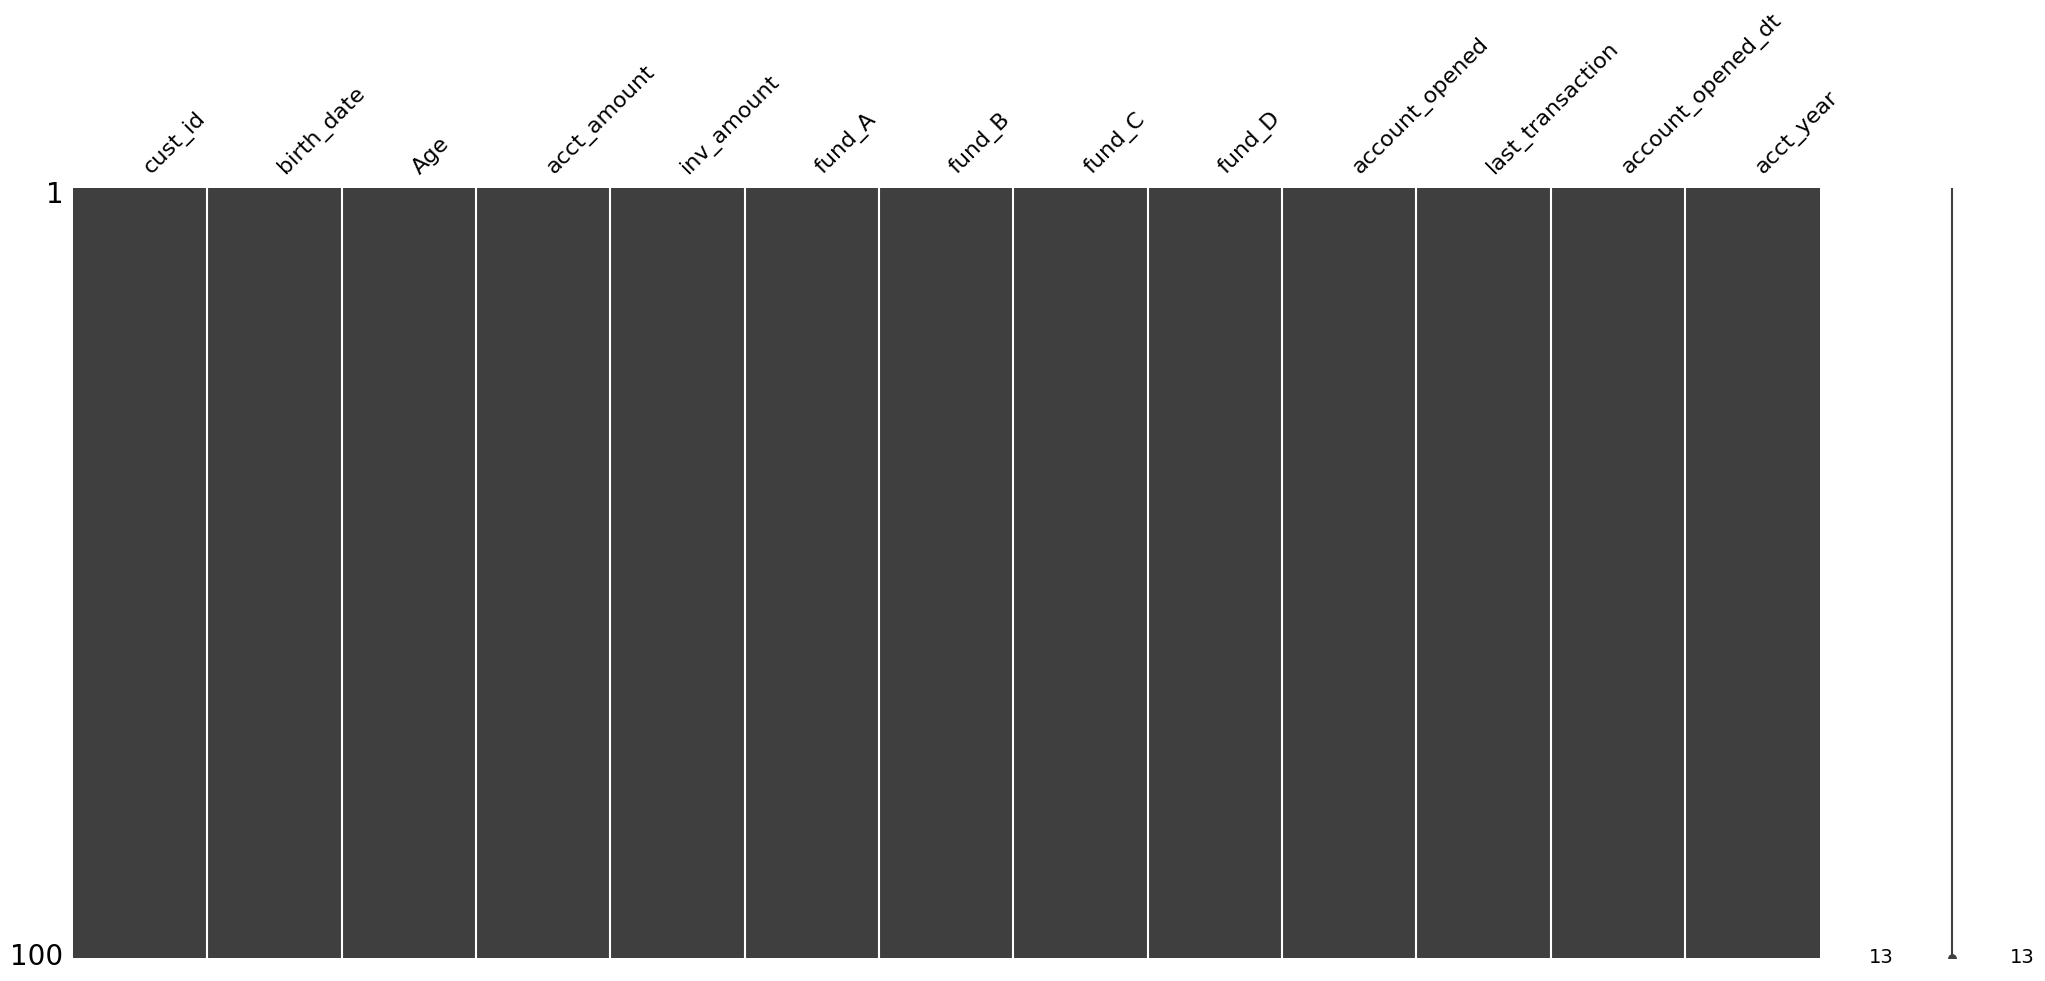

In [16]:
# Print number of missing values in banking
print(banking.isna().sum())

# Visualize missingness matrix
msno.matrix(banking)
plt.show()



      birth_date  Age  acct_amount  inv_amount  fund_A  fund_B  fund_C  \
count          0  0.0          0.0         0.0     0.0     0.0     0.0   
mean         NaT  NaN          NaN         NaN     NaN     NaN     NaN   
min          NaT  NaN          NaN         NaN     NaN     NaN     NaN   
25%          NaT  NaN          NaN         NaN     NaN     NaN     NaN   
50%          NaT  NaN          NaN         NaN     NaN     NaN     NaN   
75%          NaT  NaN          NaN         NaN     NaN     NaN     NaN   
max          NaT  NaN          NaN         NaN     NaN     NaN     NaN   
std          NaN  NaN          NaN         NaN     NaN     NaN     NaN   

       fund_D account_opened account_opened_dt  
count     0.0              0                 0  
mean      NaN            NaT               NaT  
min       NaN            NaT               NaT  
25%       NaN            NaT               NaT  
50%       NaN            NaT               NaT  
75%       NaN            NaT           

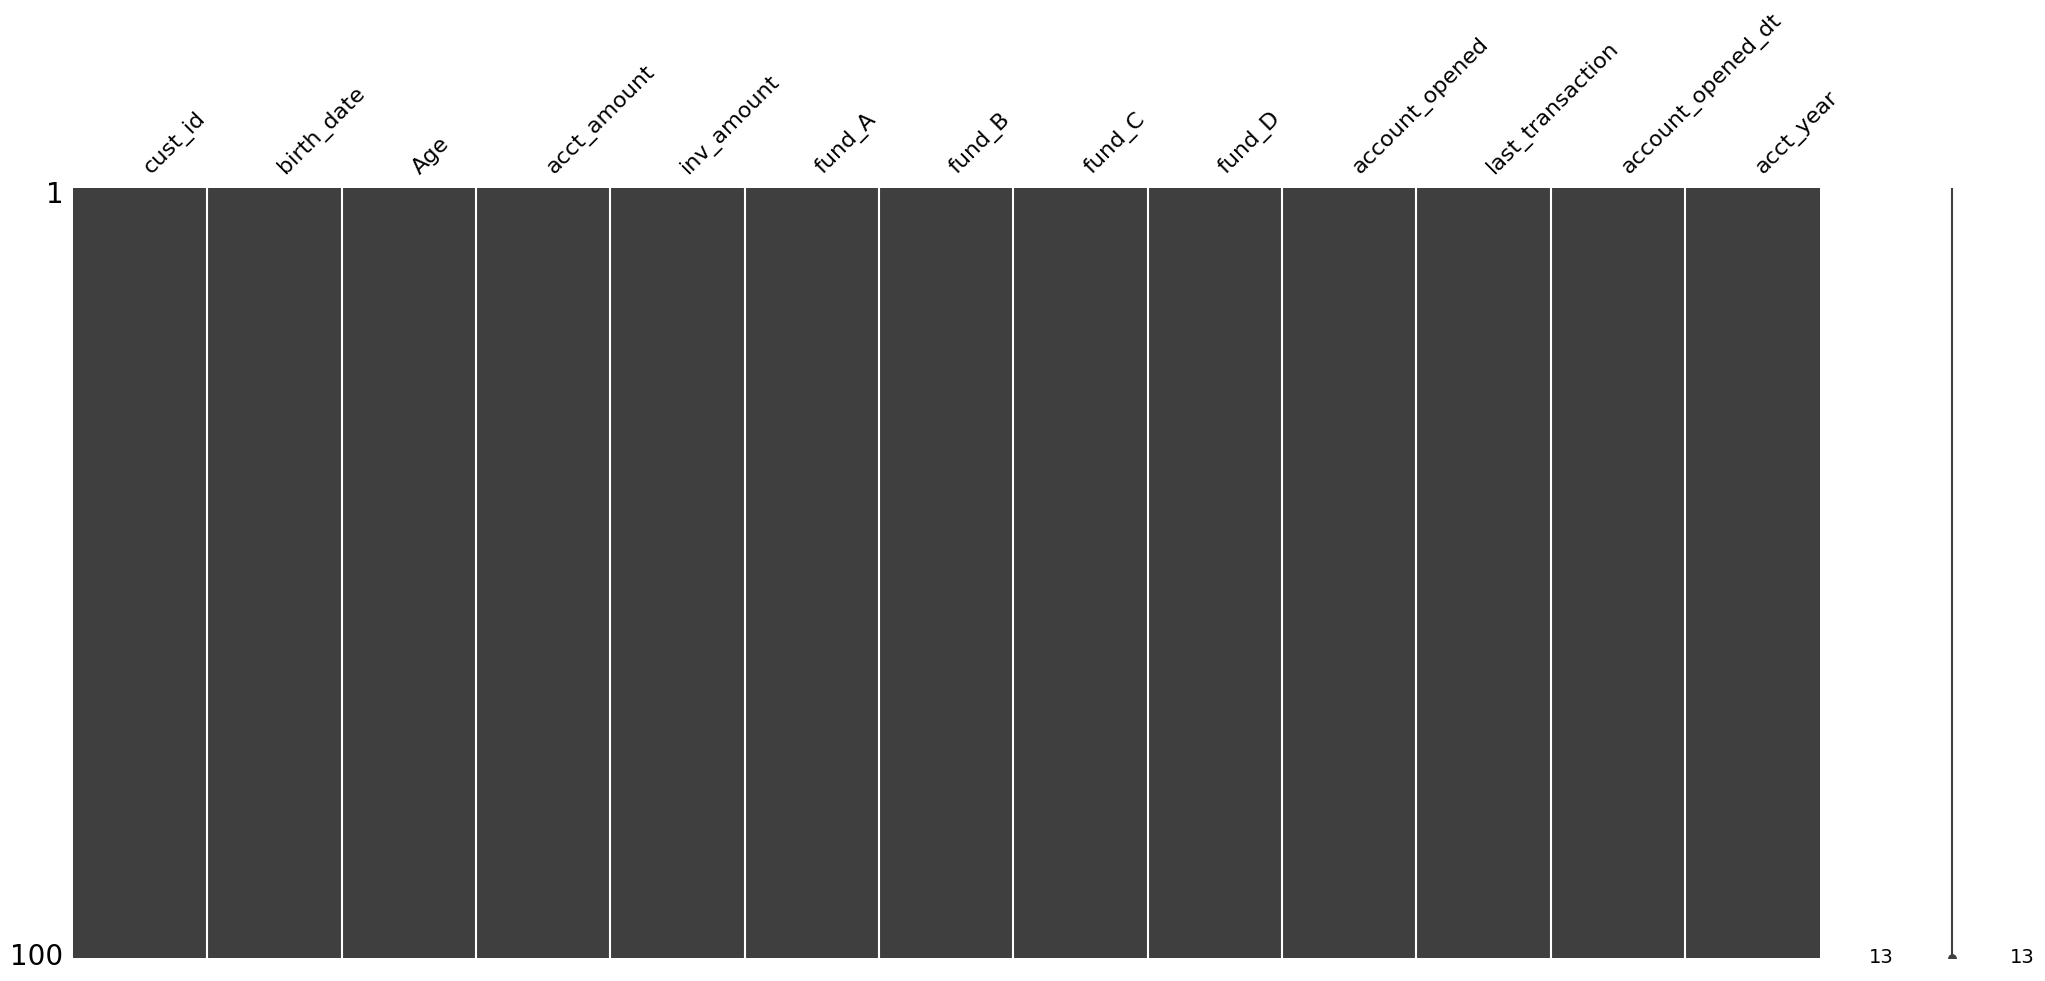

In [18]:
# Isolate missing and non missing values of inv_amount
missing_investors = banking[banking['inv_amount'].isna()]
investors = banking[~banking['inv_amount'].isna()]

# describe
print(missing_investors.describe())
print(investors.describe())

# Sort banking by age and visualize
banking_sorted = banking.sort_values('Age')
msno.matrix(banking_sorted)
plt.show()


In [19]:
# Drop missing values of cust_id
banking_fullid = banking.dropna(subset = ['cust_id'])

# Compute estimated acct_amount
acct_imp = banking_fullid['inv_amount'] * 5

# Impute missing acct_amount with corresponding acct_imp
banking_imputed = banking_fullid.fillna({'acct_amount':acct_imp})

# Print number of missing values
print(banking_imputed.isna().sum())

cust_id              0
birth_date           0
Age                  0
acct_amount          0
inv_amount           0
fund_A               0
fund_B               0
fund_C               0
fund_D               0
account_opened       0
last_transaction     0
account_opened_dt    0
acct_year            0
dtype: int64


## Record linkage

* **minimum edit distance** - how close two strings are.
  * 'intention' and 'execution'
  * first delete I from intention and adding 'C' between 'E' and 'N' -> *ntecntion (distance = 2 so far)
  * then substitute N with E, T with X, N with U (minimum edit distance = 5)
* minimum edit distance algorithms: 
  * **damerau-levenshtein** - insertion, subsitution, deletion, transposition
  * **levenshtein** - insertion, subsitution, deletion
  * **hamming** - substitution only
  * **jaro distance** - transposition only

Looking at **levenshtein** with package - `thefuzz`

```python

from thefuzz import fuzz

# compare reading and reeding
fuzz.WRatio('Reeding', 'Reading')

# output is 0-100 where 100 is a perfect match
```

comparison with arrays: 

```python

# define string and array of possible matches
string = 'Houston Rockets vs Los Angeles Lakers'
choices = pd.Series(['Rockets vs Lakers', 'lakers vs Rockets', 'Houson vs Los Angeles', 'Heat vs Bulls'])

process.extract(string, choices, limit = 2)

```

* can collapse cateories with string matching: 
* `survey['state'].unique()` -> many typo states
* `categories` -> contains valid/correct states

```python

# for each correct category
for state in categories['state']:
    # find potential matches in states with typos
    matches = process.extract(state, survey['state'], limit = survey.shape[0])
    # for each potential match match
    for potential_match in matches:
        #if high similarity score
        if potential_match[1] >=80:
            # replace typo with correct category
            survey.loc[survey['state'] == potential_match[0], 'state'] = state

```

In [ ]:
#!pip install thefuzz

# Import process from thefuzz
from thefuzz import process

# Store the unique values of cuisine_type in unique_types
unique_types = restaurants['cuisine_type'].unique()

# Calculate similarity of 'asian' to all values of unique_types
print(process.extract('asian', unique_types, limit = len(unique_types)))

# Calculate similarity of 'american' to all values of unique_types
print(process.extract('american', unique_types, limit = len(unique_types)))

# Calculate similarity of 'italian' to all values of unique_types
print(process.extract('italian', unique_types, limit = len(unique_types)))

In [ ]:
# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['cuisine_type'], limit = restaurants.shape[0])

# Inspect the first 5 matches
print(matches[0:5])

In [ ]:
# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['cuisine_type'], limit=len(restaurants.cuisine_type))

# Iterate through the list of matches to italian
for match in matches:
  # Check whether the similarity score is greater than or equal to 80
  if match[1] >= 80:
    # Select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
    restaurants.loc[restaurants['cuisine_type'] == match[0], 'cuisine_type'] = 'italian'

In [ ]:
# Iterate through categories
for cuisine in categories:  
  # Create a list of matches, comparing cuisine with the cuisine_type column
  matches = process.extract(cuisine, restaurants['cuisine_type'], limit=len(restaurants.cuisine_type))

  # Iterate through the list of matches
  for match in matches:
     # Check whether the similarity score is greater than or equal to 80
    if match[1] >= 80:
      # If it is, select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
      restaurants.loc[restaurants['cuisine_type'] == match[0]] = cuisine
      
# Inspect the final result
print(restaurants['cuisine_type'].unique())

### record linkage 

* act of linking data from different sources regarding the same entity
  * clean two or more dataframes, generate pairs of potentially matching records, score these pairs according to string similarity and link them
  * `recordlinkage` package
* `blocking` is used when scale of data does not allow to generate every possible pair

```python 
# import recordlinkage
import recordlinkage

# create indexing object
indexer = recordlinkage.Index()

#generate pairs blocked on state
indexer.block('state')
pairs = indexer.index(census_A, census_B)

# create compare object
compare_cl = recordlinkage.Compare()

# find exact matches for pairs of date_of_birth and state
compare_cl.exact('date_of_birth', 'date_of_birth', label = 'date_of_birth')
compare_cl.exact('state', 'state', label = 'state')

# find similar matches for pairs of surname and ddress_1 using string similarity
compare_cl.string('surname', 'surname', threshold = 0.85, label = 'surname')
compare_cl.string('address_1', 'address_1', threshold = 0.85, label = 'address_1')

# find matches
potential_matches = compare_cl.compute(pairs, census_A, census_B)

# isolate potential matches
potential_matches[potential_matches.sum(axis=1) => 2]

```

In [ ]:
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)

# Create a comparison object
comp_cl = recordlinkage.Compare()

# Find exact matches on city, cuisine_types - 
comp_cl.exact('city', 'city', label='city')
comp_cl.exact('cuisine_type', 'cuisine_type', label='cuisine_type')

# Find similar matches of rest_name
comp_cl.string('rest_name', 'rest_name', label='name', threshold = 0.8) 

# Get potential matches and print
potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
print(potential_matches)

print(potential_matches[potential_matches.sum(axis = 1) >= n])

### linking dataframes

after finding matching records:
* `matches.index`
* `duplicate_rows = matches.index.get_level_values(1)`
* `census_B_duplicates = census_B[census_B.index.isin(duplicate_rows)]`
* `census_B_new = census_B[~census_B.index.isin(duplicate_rows)]`
* `full_census = census_A.append(census_B_new)`

In [ ]:
# Isolate potential matches with row sum >=3
matches = potential_matches[potential_matches.sum(axis=1) >= 3]

# Get values of second column index of matches
matching_indices = matches.index.get_level_values(1)

# Subset restaurants_new based on non-duplicate values
non_dup = restaurants_new[~restaurants_new.index.isin(matching_indices)]

# Append non_dup to restaurants
full_restaurants = restaurants.append(non_dup)
print(full_restaurants)